# import stuff

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
from tqdm import tqdm
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import gen_filtered_lambda_terms_v2

from calculus_utils.drawing import *
from calculus_utils.algorithms import *

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
from calculus_utils.drawing import *
from calculus_utils.outliers_cleaning import clear_arr

In [3]:
from contextlib import contextmanager
import threading
import _thread


class TimeoutException(Exception):
    def __init__(self, msg=''):
        self.msg = msg


@contextmanager
def time_limit(seconds, msg=''):
    timer = threading.Timer(seconds, lambda: _thread.interrupt_main())
    timer.start()
    try:
        yield
    except KeyboardInterrupt:
        raise TimeoutException("Timed out for operation {}".format(msg))
    finally:
        # if the action ends in specified time, timer is canceled
        timer.cancel()

In [4]:
UPLIMIT = 60
DOWNLIMIT = 50
LAMBDA_TERM_COUNT = 200
RANDOM_AVERAGE_COUNT = 20

# Old generation (no updating bound vars) and old / new tests
## generate terms (with NO update bound vars) and norm this terms in oldstyle

In [6]:
terms_o, stepsLO_oo = gen_filtered_lambda_terms_v2(count_terms=LAMBDA_TERM_COUNT,
                                                   down_vertices_limit=DOWNLIMIT,
                                                   up_vertices_limit=UPLIMIT,
                                                   update_bound_vars=False  # made generation in old style
                                                   )

print(f"number of terms with normal form {len(terms_o)}")
print("number of steps to normalize using LO strategy= {}".format(stepsLO_oo))

number of terms with normal form 202
number of steps to normalize using LO strategy= [32, 3, 16, 8, 37, 24, 6, 3, 2, 3, 7, 8, 6, 2, 5, 3, 6, 7, 3, 1, 18, 7, 7, 2, 5, 4, 7, 10, 5, 5, 8, 6, 8, 5, 5, 4, 22, 13, 13, 24, 4, 4, 6, 1, 9, 6, 7, 7, 35, 4, 5, 3, 51, 6, 6, 6, 0, 2, 2, 7, 2, 7, 2, 7, 7, 1, 24, 3, 7, 5, 3, 8, 22, 7, 4, 16, 4, 21, 5, 9, 47, 8, 3, 8, 15, 11, 6, 5, 3, 5, 23, 5, 10, 13, 24, 3, 1, 7, 17, 4, 6, 11, 2, 3, 12, 6, 7, 12, 6, 9, 17, 17, 1, 5, 10, 3, 3, 1, 9, 10, 7, 2, 17, 9, 10, 12, 11, 10, 2, 4, 2, 9, 2, 14, 7, 4, 40, 5, 4, 4, 3, 4, 2, 4, 7, 10, 18, 14, 4, 4, 6, 3, 5, 4, 3, 4, 14, 10, 5, 17, 27, 4, 14, 7, 16, 4, 19, 6, 46, 12, 13, 31, 11, 2, 16, 1, 4, 26, 9, 3, 15, 20, 4, 8, 12, 5, 6, 1, 9, 15, 7, 10, 6, 1, 20, 14, 8, 10, 24, 1, 4, 8]


## Run old-gen terms via mixed probabs (OLD norm style)

In [7]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = []
    for term in tqdm(terms_o, desc=f"it {inx} / {iters}"):
        term_random_steps = []
        for i in range(RANDOM_AVERAGE_COUNT):
            trs = 0
            try:
                with time_limit(15, "do norm"):
                    trs = term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p),
                                         update_bound_vars=False)[1]
            except TimeoutException:
                trs = float("inf")
            term_random_steps.append(trs)
        steps.append(sum(term_random_steps) / RANDOM_AVERAGE_COUNT)

    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 202/202 [00:07<00:00, 25.92it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 26.43it/s]


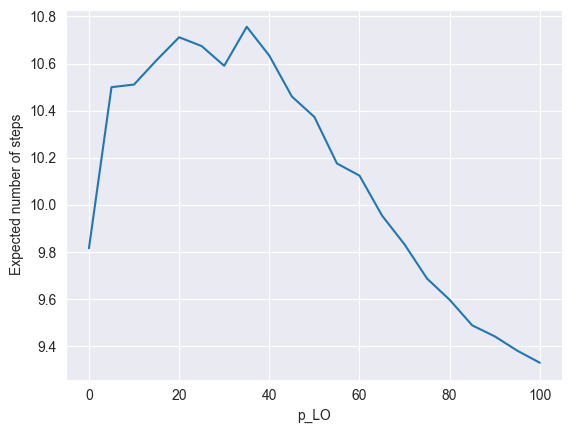

In [8]:
expected_values = []
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [9]:
ev_oo = expected_values

## Run old-gen terms via mixed probabs (NEW norm style)

In [10]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = []
    for term in tqdm(terms_o, desc=f"it {inx} / {iters}"):
        term_random_steps = []
        for i in range(RANDOM_AVERAGE_COUNT):
            trs = 0
            try:
                with time_limit(15, "do norm"):
                    trs = term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p),
                                         update_bound_vars=True)[1]
            except TimeoutException:
                trs = float("inf")
            term_random_steps.append(trs)
        steps.append(sum(term_random_steps) / RANDOM_AVERAGE_COUNT)

    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 202/202 [00:12<00:00, 16.21it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 26.21it/s]


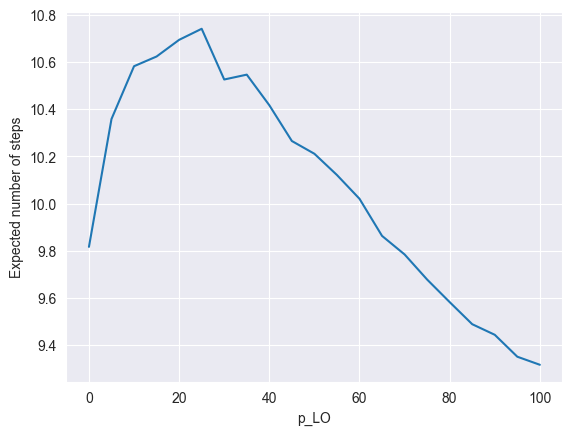

In [11]:
expected_values = []
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [12]:
ev_on = expected_values

## OLD gen: OLD norm vs NEW norm

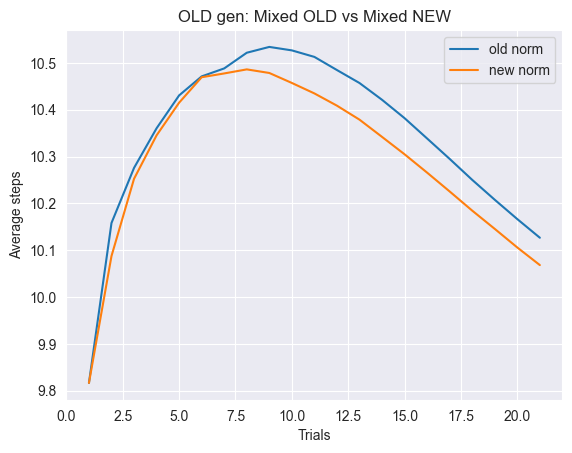

In [13]:
comp_data = {
    "old norm": (ev_oo, "-"),
    "new norm": (ev_on, "-")
}

draw_cumulative_avg_comparison(comp_data, title="OLD gen: Mixed OLD vs Mixed NEW")

# New generation (updating bound vars) and old / new tests
## generate terms (with update bound vars) and norm this terms in the new style

In [5]:
terms_n, stepsLO_nn = gen_filtered_lambda_terms_v2(count_terms=LAMBDA_TERM_COUNT,
                                                   down_vertices_limit=DOWNLIMIT,
                                                   up_vertices_limit=UPLIMIT,
                                                   update_bound_vars=True  # made generation in old style
                                                   )

print(f"number of terms with normal form {len(terms_n)}")
print("number of steps to normalize using LO strategy= {}".format(stepsLO_nn))

number of terms with normal form 200
number of steps to normalize using LO strategy= [37, 2, 3, 5, 13, 6, 6, 2, 8, 19, 7, 6, 3, 7, 7, 4, 1, 10, 7, 6, 4, 5, 4, 2, 11, 7, 5, 4, 5, 2, 6, 10, 3, 10, 5, 41, 21, 5, 2, 16, 3, 14, 1, 5, 6, 4, 2, 1, 3, 7, 4, 14, 17, 5, 2, 39, 11, 6, 6, 1, 1, 9, 3, 6, 7, 1, 12, 2, 28, 4, 3, 17, 1, 1, 1, 12, 3, 3, 20, 4, 8, 11, 4, 9, 14, 74, 11, 16, 2, 7, 13, 4, 4, 5, 2, 15, 1, 4, 6, 1, 4, 2, 6, 11, 20, 2, 8, 8, 2, 6, 4, 2, 1, 8, 6, 7, 6, 40, 44, 60, 14, 4, 13, 1, 3, 3, 2, 6, 3, 1, 19, 12, 9, 4, 4, 1, 2, 2, 12, 4, 2, 12, 9, 1, 1, 9, 3, 2, 0, 15, 2, 9, 4, 2, 1, 4, 18, 14, 2, 3, 9, 23, 21, 3, 8, 17, 9, 5, 13, 5, 8, 8, 6, 7, 22, 4, 6, 6, 4, 18, 20, 4, 1, 2, 3, 1, 13, 8, 5, 2, 32, 5, 4, 8, 5, 30, 2, 6, 6, 12]


## Run NEW-gen terms via mixed probabs (OLD norm style)

In [6]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = []
    for term in tqdm(terms_n, desc=f"it {inx} / {iters}"):
        term_random_steps = []
        for i in range(RANDOM_AVERAGE_COUNT):
            trs = 0
            try:
                with time_limit(15, "do norm"):
                    trs = term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p),
                                         update_bound_vars=False)[1]
            except TimeoutException:
                trs = float("inf")
            term_random_steps.append(trs)
        steps.append(sum(term_random_steps) / RANDOM_AVERAGE_COUNT)

    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 200/200 [00:05<00:00, 34.07it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 27.63it/s]


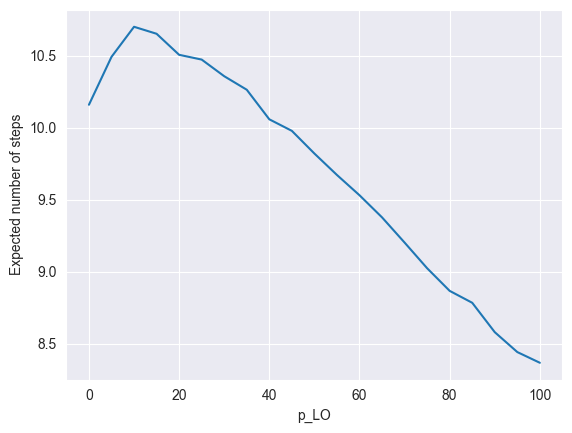

In [7]:
expected_values = []
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [8]:
ev_no = expected_values

## Run NEW-gen terms via mixed probabs (NEW norm style)

In [9]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = []
    for term in tqdm(terms_n, desc=f"it {inx} / {iters}"):
        term_random_steps = []
        for i in range(RANDOM_AVERAGE_COUNT):
            trs = 0
            try:
                with time_limit(15, "do norm"):
                    trs = term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p),
                                         update_bound_vars=True)[1]
            except TimeoutException:
                trs = float("inf")
            term_random_steps.append(trs)
        steps.append(sum(term_random_steps) / RANDOM_AVERAGE_COUNT)

    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 200/200 [00:09<00:00, 22.21it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 26.18it/s]


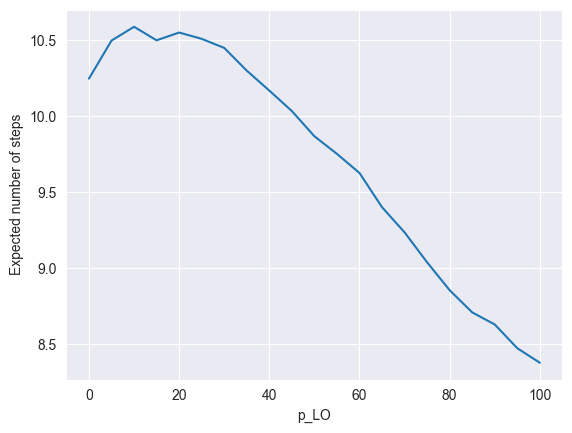

In [10]:
expected_values = []
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [11]:
ev_nn = expected_values

## OLD gen: OLD norm vs NEW norm

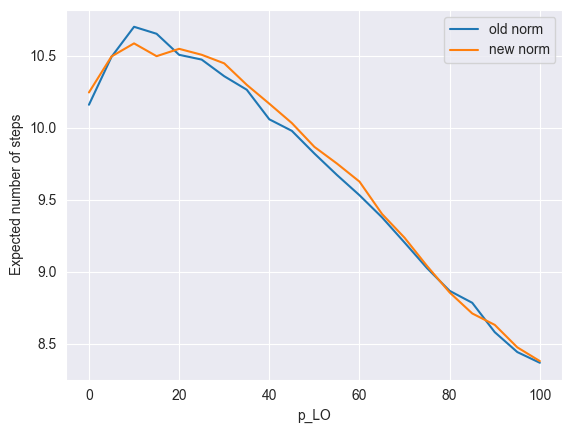

In [15]:
plt.plot(values, ev_no, "-", label="old norm")
plt.plot(values, ev_nn, "-", label="new norm")
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.legend(loc="upper right")
plt.show()